In [1]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
import plotly.io as pio
import pickle
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 


3.2.25.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4


In [2]:
# gdf = gpd.read_file("../data/iris/contours-iris.gpkg")
# gdf = gdf.to_crs(epsg=4326)
# gdf["fid"] = gdf.index
# gdf["lon"] = gdf.geometry.centroid.x
# gdf["lat"] = gdf.geometry.centroid.y
# gdf = gdf.sort_values(by="code_iris")
# with open("../data/iris/gdf.pickle", "wb") as f:
#     pickle.dump(gdf, f)
with open("../data/iris/gdf.pickle", "rb") as f:
    gdf_france = pickle.load(f)
    geojson=gdf_france.__geo_interface__
    len(gdf_france)

In [3]:
years = list(range(20,26))
spe_df = pd.read_sql("select id, label, label_long from specialite order by id", config.connection_string, index_col="id")
spe_df.T

id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
label,Psychiatre,Anest,Dermato,Gastro,Gyneco,Opthtalmo,Pediatre,Radio,Dentiste,Generaliste,Cardio,Chirugien,Endocrino,Geriatre,Neuro,ORL,Pneumo,Radiotherapeuthe,Rhumato,Stomato,Infirmier
label_long,Psychiatre,Anesthésiste,Dermatologue,Gastro-entérologue,Gynécologue,Opthtalmogue,Pédiatre,Radiologue,Dentiste,Généraliste,Cardiologue,Chirugien,Endocrinologue,Gériatre,Neurologue,Oto-rhino-laryngologiste,Pneumologue,Radiothérapeuthe,Rhumatologue,Stomatologue,Infirmier


Documentation

code_commune: il y a plusieurs possibilités :
* le code de la commune sur 5 chiffres, par exemple "06088" pour Nice
* certains anciens code commune sont acceptés comme 75101 pour Paris 1er arrondissement
* le département sur 2 chiffres, par exemple "06"
* le code IRIS sur 9 chiffres, par exemple "382050000"
* une liste de code IRIS entre crochet, par exemple \["385480000", "382050000"]
* une liste de code commune entre crochet, par exemple \["38548", "38205"]
* une liste de département entre crochet, par exemple \["06", "83"]
* le code IRIS avec un joker sql de type "3820%"
* pour la corse utiliser les préfixes 2A ou 2B et non 20, par exemple "2A004"

specialite: voir tableau ci dessus

source: "PA" pour ps_libreacces ou "PS"

time: 30 ou 45, il est possible d'en faire d'autre mais il faut lancer les calculs

time_type: "HC" ou "HP"

aexp: -0.12 ou -0.1 ou -0.08 ou -0.06 ou -0.04<br>
Pour time==30 aexp: -0.12 ou -0.1 ou -0.08<br>
Pour time==45 aexp: -0.08 ou -0.06<br>
Pour time==60 aexp: -0.06 ou -0.04

norm_colorbar = True si normalisé sur France entière False sinon

meanw_colorbar = True si normalisé sur moyenne pondérée, False si normalisé sur Médiane

Pour ne plus voir les labels sur les IRIS mettre limit_show=0

Puis appuyer sur le bouton Restart (bouton avec double flèche à droite FFW) ou dans le menu Run / Run selected cell and all below

In [4]:
code_commune="38185" #"75101" #"75056" #"69123" #"38185"  #"06088" "38205" "38548" "2A004" "382050000" ["385480000", "382050000"] ["38548", "38205"] "45" "14581" bug
specialite = 10
source="PA" # PA or PS
time=30 # 30 or 45
time_type="HC" # HC or HP
aexp=-0.12 # -0.12 or -0.1 or -0.08 or -0.06 or -0.04
norm_colorbar=True
meanw_colorbar=False
limit_show_label=100
code_commune,specialite,source,time,time_type,aexp,norm_colorbar,meanw_colorbar

('38185', 10, 'PA', 30, 'HC', -0.12, True, False)

In [5]:
if type(code_commune) is list:
    if len(code_commune[0])==5:
        type_code="CLIST"
    elif len(code_commune[0])==9:
        type_code = "ILIST"
    elif len(code_commune[0])==2:
        type_code = "DLIST"
    else:
        raise ValueError(f"Bad {code_commune}")    
elif "%" in code_commune and len(code_commune) > 2:
    type_code = "LIKE"
elif len(code_commune) == 2:
    type_code = "LIKE"
    code_commune = code_commune + "%"
elif len(code_commune) == 5:
    type_code = "COM"
elif len(code_commune) == 9:
    type_code = "IRIS"
else:
    raise ValueError(f"Bad {code_commune}")
print(f"Type code: {type_code} for {code_commune}")

Type code: COM for 38185


In [6]:
sql = f"""
select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code='{code_commune}'
order by i.id
"""
commune_nom = None
iriss=[]
if type_code=="COM":
    iris_df = pd.read_sql(sql, config.connection_string)
    iriss = iris_df["code"].values
    commune_nom = iris_df["commune_nom"].iloc[0] if len(iris_df) > 0 else None
elif type_code in ["IRIS", "LIKE"]:
    iriss = [code_commune]
elif type_code == "ILIST":
    iriss = code_commune
elif type_code == "CLIST":
    sql = f"""
select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code in {tuple(code_commune)}
"""
    print(sql)
    iris_df = pd.read_sql(sql, config.connection_string)
    iriss = iris_df["code"].values
    commune_nom = iris_df["commune_nom"].iloc[0] if len(iris_df) > 0 else None
print(f"Found {len(iriss)} iris for {commune_nom}")

if type_code == "LIKE":
    gdf = gdf_france[gdf_france["code_iris"].str.startswith(code_commune[:-1])]
elif type_code == "DLIST":
    gdf = gdf_france[gdf_france["code_iris"].str.startswith(tuple(code_commune))]
elif len(iriss)>0:
    gdf = gdf_france[gdf_france["code_iris"].isin(iriss)]
else:
    gdf = gdf_france[gdf_france["code_insee"]==code_commune]
    type_code="INSEE"

if commune_nom is None:
    commune_nom=gdf["nom_commune"].iloc[0] if len(gdf) > 0 else None
    print(f"Found {len(gdf)} iris in {commune_nom}")
geojson=gdf.__geo_interface__
print(f"Found {len(gdf)} geo iris for {commune_nom}, type_code: {type_code}")
# gdf_france[gdf_france["nom_commune"].str.startswith("Lyon")].head(100)
gdf.head(2)

Found 70 iris for Grenoble
Found 70 geo iris for Grenoble, type_code: COM


,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat
38,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669
3489,IRIS____0000000381850102,38185,Grenoble,0102,381850102,Jean Macé,H,"MULTIPOLYGON (((5.68498 45.21175, 5.68849 45.2...",3489,5.707723,45.202059


In [7]:
def get_study_by_year(year):
    sql = f"""
    select * from apl.apl_study s
    where s.specialite_id={specialite}
    and s.year={year}
    and s.source='{source}'
    and s.time={time}
    and s.time_type='{time_type}'
    and s.exp={aexp}
    order by date desc
    limit 1
    """
    return pd.read_sql(sql, config.connection_string)

def get_studies_by_years(years: list[int]):
    df = None
    for year in years:
        if df is None:
            df = get_study_by_year(year)
        else:
            df = pd.concat([df, get_study_by_year(year)], ignore_index=True)
    return df
        
        
    
studies_df = get_studies_by_years(years)
studies_df

,year,specialite_id,source,time,time_type,exp,mean,std,q10,q25,q50,q75,q90,min,max,date,key,meanw
0,20,10,PA,30,HC,-0.12,65.756899,36.094978,29.184564,40.109085,56.695908,84.178988,117.240950,0.0,729.717071,2026-01-26 18:14:32.236,538429955477,83.967253
1,21,10,PA,30,HC,-0.12,64.756920,35.634202,28.476525,39.346180,55.853017,83.043708,115.804031,0.0,698.242979,2026-01-26 21:36:16.958,492082220222,82.745588
2,22,10,PA,30,HC,-0.12,63.778794,35.497153,27.667626,38.573803,54.861608,81.755892,114.580526,0.0,697.801416,2026-01-27 00:49:40.341,208181222198,81.611906
3,23,10,PA,30,HC,-0.12,63.742926,35.694050,27.375649,38.519425,54.783652,81.527902,115.370574,0.0,671.098376,2026-01-27 04:03:21.825,192983174442,81.566054
4,24,10,PA,30,HC,-0.12,63.137568,36.209441,26.361996,37.478587,54.028292,81.039424,114.684536,0.0,671.109886,2026-01-27 07:15:03.061,137706272959,80.992540
5,25,10,PA,30,HC,-0.12,62.887939,36.073225,26.073988,37.198113,53.797969,80.952666,113.884214,0.0,671.109886,2026-01-27 10:28:33.131,483729913004,80.692426


In [8]:
keys = studies_df["key"].values
print(f"Studies keys: {keys}")
if type_code == "COM":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and code_commune='{code_commune}'
    """
elif type_code == "IRIS":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string='{code_commune}'
    """
elif type_code == "LIKE":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string like '{code_commune}'
    """
elif type_code == "DLIST":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string like any (array{[c+'%' for c in code_commune]})
    """    
elif type_code == "ILIST":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string in {tuple(code_commune)}
    """
elif type_code == "CLIST":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.code_commune in {tuple(code_commune)}
    """
print(sql)
apl = pd.read_sql(text(sql), config.connection_string)
if type_code == "INSEE" or len(apl) == 0:
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    """
    apl = pd.read_sql(sql, config.connection_string)
apl

Studies keys: [538429955477 492082220222 208181222198 192983174442 137706272959
 483729913004]

    select * from apl.apl a
    where a.study_key in (538429955477, 492082220222, 208181222198, 192983174442, 137706272959, 483729913004)
    and code_commune='38185'
    


,year,specialite,iris,iris_string,type_iris,nb,apl,ap,accessibilite_weight,R,wpop,swpop,pop_gp,pop,iris_label,dept,code_commune,commune_label,study_key,meanw,specialite_id,source,time,time_type,exp,mean,std,q10,q25,q50,q75,q90,min,max,date,key
0,20,10,381850101,381850101,C,0.000000,130.104879,0.000000,1.0,0.000000,32.872008,142579.908398,32.872008,40.000070,Polygone,38,38185,Grenoble,538429955477,3.241131,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,20,10,381850102,381850102,A,1.250000,126.886602,0.853392,1.0,0.853392,3912.923495,146474.293669,3912.923495,4816.525831,Jean Macé,38,38185,Grenoble,538429955477,376.265020,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,20,10,381850103,381850103,A,1.250000,134.681653,0.794210,1.0,0.794210,1980.893099,157389.071855,1980.893099,2559.407977,Europole,38,38185,Grenoble,538429955477,202.183728,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,20,10,381850104,381850104,A,3.000000,147.299812,1.752643,1.0,1.752643,2166.355735,171170.051235,2166.355735,2545.943311,Diderot,38,38185,Grenoble,538429955477,241.829172,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,20,10,381850105,381850105,A,0.250000,156.537159,0.137764,1.0,0.137764,1425.927997,181470.176674,1425.927997,1661.741793,Gare,38,38185,Grenoble,538429955477,169.157698,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,25,10,381850607,381850607,A,0.000000,128.182192,0.000000,1.0,0.000000,1431.978557,165748.054826,1431.978557,1672.736037,Baladins,38,38185,Grenoble,483729913004,138.423998,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
416,25,10,381850608,381850608,A,0.000000,140.312964,0.000000,1.0,0.000000,5071.459432,183302.248384,5071.459432,5854.680322,Vigny-Musset,38,38185,Grenoble,483729913004,536.633692,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
417,25,10,381850609,381850609,A,1.000000,135.733389,0.566633,1.0,0.566633,1486.081530,176481.086039,1486.081530,1720.047629,Village Olympique Nord,38,38185,Grenoble,483729913004,152.116565,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
418,25,10,381850610,381850610,A,0.250000,135.162218,0.141124,1.0,0.141124,1380.777584,177148.664142,1380.777584,1624.084717,Village Olympique Sud,38,38185,Grenoble,483729913004,140.742810,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [9]:
if len(apl[apl["iris_string"]=="180331201"])>0 and len(apl[apl["iris_string"]=="181740000"])>0:
    apl.loc[apl["iris_string"]=="180331201","apl"]=apl[apl["iris_string"]=="181740000"]["apl"].iloc[0]
if len(apl[apl["iris_string"]=="140110000"])>0:
    apl.loc[apl["iris_string"]=="140110000","iris_string"]="145810000"

In [10]:
apl["code_iris"]=apl["iris_string"]
gdf_merged = gdf.merge(apl, on="code_iris", how="left", suffixes=('', '_dest')).copy()
gdf_merged["pretty"]=gdf_merged["apl"].fillna(0).apply(lambda x: round(x, 0)).astype(np.int32)
gdf_merged["pop_ajustee"]=gdf_merged['pop_gp']
apl20 = gdf_merged.loc[gdf_merged['year']==20, ['iris_dest', 'apl']].set_index('iris_dest')['apl']
gdf_merged["year20"]=gdf_merged['iris_dest'].map(apl20).fillna(0)
gdf_merged["diff20"]=gdf_merged["apl"]-gdf_merged["year20"]
gdf_merged["delta20"]=gdf_merged["diff20"]/(gdf_merged["year20"]+1e-5)
gdf_merged

,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat,year,specialite,iris_dest,iris_string,type_iris_dest,nb,apl,ap,accessibilite_weight,R,wpop,swpop,pop_gp,pop,iris_label,dept,code_commune,commune_label,study_key,meanw,specialite_id,source,time,time_type,exp,mean,std,q10,q25,q50,q75,q90,min,max,date,key,pretty,pop_ajustee,year20,diff20,delta20
0,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,20,10,381850101,381850101,C,0.000000,130.104879,0.000000,1.0,0.000000,32.872008,142579.908398,32.872008,40.000070,Polygone,38,38185,Grenoble,538429955477,3.241131,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,130,32.872008,130.104879,0.000000,0.000000
1,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,21,10,381850101,381850101,C,0.000000,128.708515,0.000000,1.0,0.000000,33.277469,142829.043143,33.277469,40.000053,Polygone,38,38185,Grenoble,492082220222,3.229903,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,129,33.277469,130.104879,-1.396364,-0.010733
2,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,22,10,381850101,381850101,C,0.000000,125.532943,0.000000,1.0,0.000000,33.209237,142885.063289,33.209237,40.000053,Polygone,38,38185,Grenoble,208181222198,3.143458,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,126,33.209237,130.104879,-4.571936,-0.035140
3,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,23,10,381850101,381850101,C,0.000000,127.829322,0.000000,1.0,0.000000,33.288452,142855.788945,33.288452,40.000053,Polygone,38,38185,Grenoble,192983174442,3.209325,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,128,33.288452,130.104879,-2.275557,-0.017490
4,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,24,10,381850101,381850101,C,0.000000,129.099701,0.000000,1.0,0.000000,33.437654,142942.766910,33.437654,40.000053,Polygone,38,38185,Grenoble,137706272959,3.255429,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,129,33.437654,130.104879,-1.005177,-0.007726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,21,10,381850611,381850611,C,0.166667,147.179949,0.090854,1.0,0.090854,0.000000,183443.987134,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,492082220222,0.000000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,147,0.000000,149.326849,-2.146900,-0.014377
416,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,22,10,381850611,381850611,C,0.166667,142.674338,0.090809,1.0,0.090809,0.000000,183534.878889,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,208181222198,0.000000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,143,0.000000,149.326849,-6.652511,-0.044550
417,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,23,10,381850611,381850611,C,0.250000,148.424543,0.136254,1.0,0.136254,0.000000,183481.268504,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,192983174442,0.000000,None,None,None,None,None,None,N

In [11]:
qmaxs = []
q90s = []
q75s = []
q50s = []
q25s = []
q10s = []
meanws = []
gdf_merged["apl_clip"]=gdf_merged["apl"]
for year in years:
    meanw = 1
    try:
        meanw = studies_df[studies_df["year"]==year]["meanw"].iloc[0]
    except:
        pass
    meanws.append(meanw)
    qmaxs.append(studies_df[studies_df["year"]==year]["max"].iloc[0] if studies_df[studies_df["year"]==year]["max"].iloc[0] != 0 else 1.0)
    if meanw_colorbar:
        q50s.append(meanw)
        q25s.append(meanw / 2)
        q10s.append(meanw / 5)
        q90s.append(meanw * 2)
        q75s.append(meanw * 1.5)
    else:
        q90=studies_df[studies_df["year"]==year]["q90"].iloc[0] if studies_df[studies_df["year"]==year]["q90"].iloc[0] != 0 else 1.0
        q90s.append(q90)
        q75=studies_df[studies_df["year"]==year]["q75"].iloc[0] if studies_df[studies_df["year"]==year]["q75"].iloc[0] != 0 else 0.0
        q75s.append(q75)
        q50=studies_df[studies_df["year"]==year]["q50"].iloc[0] if studies_df[studies_df["year"]==year]["q50"].iloc[0] != 0 else q75
        q50s.append(q50)
        q25=studies_df[studies_df["year"]==year]["q25"].iloc[0] if studies_df[studies_df["year"]==year]["q25"].iloc[0] != 0 else q50
        q25s.append(q25)
        q10s.append(studies_df[studies_df["year"]==year]["q10"].iloc[0] if studies_df[studies_df["year"]==year]["q10"].iloc[0] != 0 else q25)
    gdf_merged.loc[gdf_merged["year"]==year,"apl_clip"]=gdf_merged[gdf_merged["year"]==year]["apl"].clip(0,q90s[year-years[0]])
meanws
q90s

[117.24094994025876,
 115.8040305876132,
 114.5805260670653,
 115.37057433118218,
 114.68453618760239,
 113.88421430122473]

In [12]:
gdf_merged["apl" if norm_colorbar else "apl"]

0      130.104879
1      128.708515
2      125.532943
3      127.829322
4      129.099701
          ...    
415    147.179949
416    142.674338
417    148.424543
418    146.906944
419    143.965135
Name: apl, Length: 420, dtype: float64

C:\Users\conta\git-CVC\Skema\git-skema\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


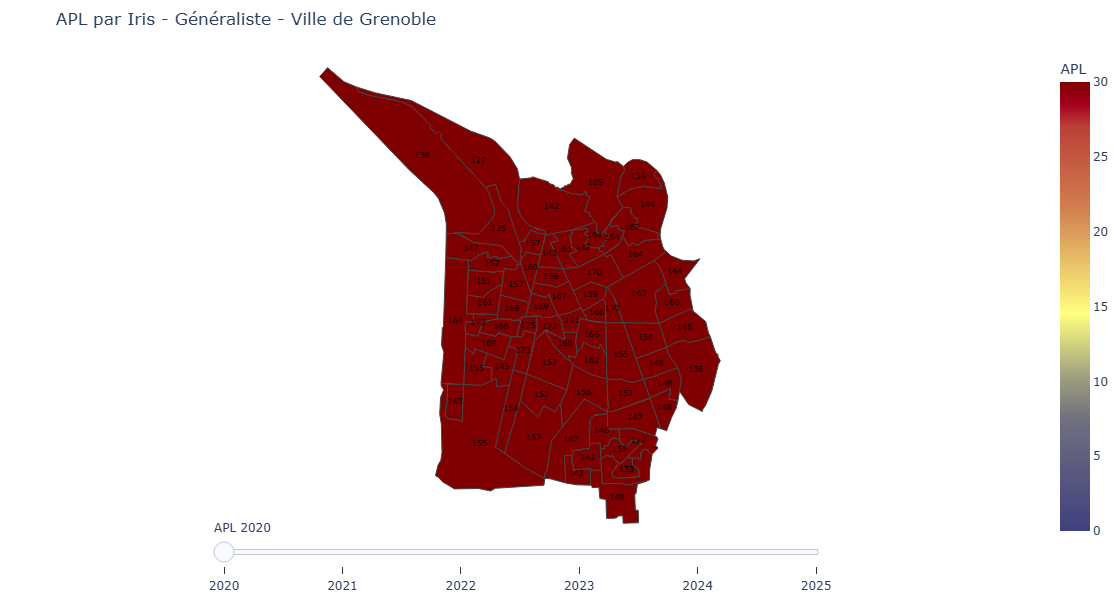

In [13]:
show_label=len(gdf) < limit_show_label
gdf["geometry"]=gdf["geometry"].simplify(0.0001) # Pays 0.01 Dept 0.001
geojson=gdf.__geo_interface__
fig = go.Figure()
l=[]
l2=[]
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()
for year in years:
    gdf_year=gdf_merged[gdf_merged["year"]==year]
    l.append(
        go.Choropleth(
            visible=False,
            geojson=geojson,
            locations=gdf_year["fid"],
            z=gdf_year["apl"], #gdf_year["apl_clip" if norm_colorbar else "apl"] juste en local,
            zmin=0,
            zmax=30, # q90s[0] if norm_colorbar else None, # zmax=q90s[year-years[0]] if norm_colorbar else None, juste en local
            text=gdf_year.apply(
                lambda row: f"Commune: {row["nom_commune"]}<br>Iris: {row["code_iris"]}<br>Nom Iris: {row['nom_iris']}<br>APL 20{year}: {row['apl']:.1f}<br>Variation APL/2020: {row['delta20']*100:+.0f}%<br>{"Moyenne pondérée" if meanw_colorbar else "Médiane"} nationale APL: {(row["apl"]-q50s[year-years[0]])*100/(q50s[year-years[0]]+0.001):+.0f}% ({q50s[year-years[0]]:.1f})<br>Nb ETP: {row['nb']:.1f}<br>Population: {row['pop']:.0f}<br>Population ajustée: {row['pop_ajustee']:.0f}<br>Population alentour: {row['swpop']:.0f}<br>APL local: {row['R']:.1f} ({row['R']*100/(row['apl']+1e-5):.0f}% APL)",
                axis=1
            ),
            hoverinfo="text",
            showscale=True,
            # colorbar={"title": f"APL 20{year}",
            #           "tickvals": [0, q10s[year-years[0]], q25s[year-years[0]], q50s[year-years[0]], q75s[year-years[0]], q90s[year-years[0]]] if norm_colorbar else None,
            #           "ticktext": ['0', f'{q10s[year-years[0]]:.0f} - 1er décile', f'{q25s[year-years[0]]:.0f} - 1er quartile', f'{q50s[year-years[0]]:.0f} - médiane', f'{q75s[year-years[0]]:.0f} - 3ème quartile', f'{q90s[year-years[0]]:.0f} - dernier décile'] if norm_colorbar else None,
            #          },
            colorbar={"title": f"APL", # 20{year}",
                      #"tickvals": [0, q10s[0], q25s[0], q50s[0], q75s[0], q90s[0]] if norm_colorbar else None,
                      #"ticktext": ['0', f'{q10s[0]:.0f} {"" if meanw_colorbar else "- 1er décile"}', f'{q25s[0]:.0f} {"" if meanw_colorbar else "- 1er quartile"}', f'{q50s[0]:.0f} - {"moyenne" if meanw_colorbar else "médiane"}', f'{q75s[0]:.0f} {"" if meanw_colorbar else "- 3ème quartile"}', f'{q90s[0]:.0f} {"" if meanw_colorbar else "- dernier décile"}'] if norm_colorbar else None,
                     },
            colorscale=[[0.0, "rgb(64,64,127)"],
                        [min(q10s[0]*1.0/q90s[0],0.25) if norm_colorbar else 0.1, "rgb(112,112,127)"],
                        [min(q25s[0]*1.0/q90s[0],0.5) if norm_colorbar else 0.25, "rgb(159,159,127)"],
                        [min(q50s[0]*1.0/q90s[0],0.75) if norm_colorbar else 0.50, "rgb(255,255,127)"],
                        [min(q75s[0]*1.0/q90s[0],0.89) if norm_colorbar else 0.75, "rgb(209,127,79)"],
                        [0.90, "rgb(187,64,55)"],
                        [0.95, "rgb(165,0,32)"],
                        [1.0, "rgb(127,0,0)"]
                       ]
        ))
    if show_label:
        l2.append(
            go.Scattergeo(
                lon=gdf_year["lon"],
                lat=gdf_year["lat"],
                text=gdf_year["pretty"].astype(str),
                mode="text",
                textfont=dict(color="black", size=8),
                hoverinfo="skip",
                showlegend=False,
                visible=False,
                marker=dict(
                        color='#99ff99',
                        size=8,
                        line=dict(
                            color='#006600',
                            width=2
                        )
                    ),
            ))
fig = go.Figure(data=l+l2)   
fig.data[0].visible = True
if show_label:
    fig.data[len(l)].visible = True
steps = []
i=0
for year in years:
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
             ],
        label=f"20{year}",
    )
    step["args"][0]["visible"][i] = True
    if show_label:
        step["args"][0]["visible"][i+len(l)] = True
    steps.append(step)
    i+=1

sliders = [dict(
    active=0,
    currentvalue={"prefix": "APL ", "visible":True},
    steps=steps,
    transition={'duration': 300, 'easing': 'cubic-in-out'},
    pad=dict(l=0, r=0, t=0, b=10),
    len=0.6,
    x=0.2,
    y=0.05,
)]

s = ""
if type_code == "DLIST":
    s = f"Departements "
    for c in code_commune:
        s += c + " "
elif type_code == "LIKE" and len(code_commune)==3:
    s = f"Departement {code_commune[:-1]}"
elif type_code == "LIKE":
    s += code_commune
elif type_code in ["COM", "IRIS"]:
    s =f"Ville de {commune_nom}"

fig.update_layout(
    sliders=sliders,
    geo=dict(
        projection_type="mercator",
        center={"lat": center_lat, "lon": center_lon},
        fitbounds="locations",
        # center_lon=center_lon,
        # center_lat=center_lat,
        # lonaxis_range=(center_lon-0.1, center_lon+0.1),
        # lataxis_range=(center_lat-0.1, center_lat+0.1),
        showland=False,
        showcountries=False,
        showocean=False,
        showlakes=False,
        showrivers=False,
        visible=False,
    ),
    title=f"APL par Iris - {spe_df.loc[specialite]["label_long"]} - {s}",
    # height=1000,
    # width=1200,
    height=600,
    # width=2000,  
    autosize=False,
    margin=dict(l=10, r=0, t=50, b=10),
)

fig.show()

In [14]:
gdf_merged["apl"].describe().apply("{0:.0f}".format)

count    420
mean     150
std       13
min      106
25%      142
50%      151
75%      160
max      175
Name: apl, dtype: object

In [15]:
fig.update_layout(
    height=None,
    width=None, 
    autosize=True,
    # margin=dict(l=10, r=0, t=50, b=50)
)
s = code_commune.replace("%","") if type(code_commune) is not list else str(code_commune).replace(" ","")
print(s)
pio.write_html(fig, file=f"out/apl_slider_{s}_{source}_{time}_{time_type}_{aexp}_{'meanw' if meanw_colorbar else 'median'}{'' if norm_colorbar else '_nonorm'}_{spe_df.loc[specialite].iloc[0]}.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})

38185


In [16]:
dico={"center_lat": center_lat, "center_lon": center_lon, "q": code_commune, "commune_nom": commune_nom, "meanws": meanws, "label": spe_df.loc[specialite]["label_long"], "years": {}}
export = gdf_merged[['code_insee', 'nom_commune', 'code_iris', 'nom_iris', 'lon', 'lat', 'fid', 'year', 'nb', 'apl', 'apl_clip', 'R', 'swpop', 'pop', 'pop_ajustee']]
for year in years:
    export_year = export[export["year"]==year] 
    dico_year = {}
    for col in export.columns:
        dico_year[col]=export_year[col].values.tolist()
    dico["years"][year + 2000] = dico_year
dico
geos = json.dumps(geojson)
s = json.dumps(dico)
with open(f"out/{code_commune}_years.json", "w") as f:
    f.write(f"[{s},{geos}]")
s[:1000]

'{"center_lat": 45.18001347268411, "center_lon": 5.724869813610877, "q": "38185", "commune_nom": "Grenoble", "meanws": [83.96725322391758, 82.74558797871786, 81.6119062548563, 81.56605402433328, 80.99253954602248, 80.69242552811461], "label": "G\\u00e9n\\u00e9raliste", "years": {"2020": {"code_insee": ["38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185", "38185"], "nom_commune": ["Grenoble", "Grenoble", "Grenoble", "Grenoble", "